# OCEAN Token Sentiment Analysis Challenge
## Part II

By Luca Ordronneau

In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import ast
import requests
from io import StringIO

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import re
import json
import string
import itertools

import contractions

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
wn.ensure_loaded()

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)

import plotly.io as pio
pio.templates.default = 'plotly_white'
pio.templates['plotly_white']['layout']['font']['family'] = "Arial"

FREQ = 'D'

## OCEAN Price
### 1min OCEAN candles data (FreqTrade)

In [2]:
def load_pair_data(input_pair):
    df = pd.read_json(input_pair, orient='values')
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    df = df.astype(dtype={'open': 'float', 'high': 'float',
                          'low': 'float', 'close': 'float', 'volume': 'float'})
    df['date'] = pd.to_datetime(df['date'],
                                unit='ms',
                                utc=True,
                                infer_datetime_format=True)
    return df

Format Price and Tweets dataframe

In [3]:
df_tweet = pd.read_csv('../data/$OCEAN tweets dataset.csv')
print('Total tweets:', len(df_tweet))
df_tweet = df_tweet[df_tweet["language"] == "en"] # Keep only English tweets
print('Total english tweets:', len(df_tweet))
df_price = pd.read_csv('../data/OCEAN token price dataset.csv')

df_price['Date'] = pd.to_datetime(df_price['Date'])
df_tweet['date'] = pd.to_datetime(df_tweet['date']+' '+df_tweet['time'])

df_price.sort_values(by="Date", inplace=True)
df_tweet.sort_values(by="date", inplace=True)

Total tweets: 229857
Total english tweets: 187342


In [4]:
df_price.columns = df_price.columns.str.lower()
df_price.set_index('date', inplace=True)
df_price = df_price.resample('1T').asfreq()
df_price[['open', 'high', 'low', 'close', 'adj close', 'volume']] = df_price[['open', 'high', 'low', 'close', 'adj close', 'volume']].interpolate(method='linear')
df_price.reset_index(inplace=True)

Get Freqtrade 1min candles price data

In [5]:
df_price_1m = load_pair_data('../data/OCEAN_USDT-1m.json')
df_price_1m['date'] = pd.to_datetime(df_price_1m['date'])

In [6]:
min_date = df_price_1m['date'].min().to_datetime64()
df_missing_price = df_price[df_price['date'] < min_date]
df_missing_price['date'] = df_missing_price['date'].dt.tz_localize('UTC')

In [7]:
df_price = pd.concat([df_missing_price, df_price_1m]).reset_index(drop=True)

In [8]:
df_price['date'] = pd.to_datetime(df_price['date']).dt.tz_convert(None)
df_tweet['date'] = pd.to_datetime(df_tweet['date'])

df_price['futur_close'] = df_price['close'].shift(-240)
df_price['4h_change'] = (df_price['futur_close'] - df_price['close']) / df_price['close']
df_price['4h_change'] = df_price['4h_change'] / max(abs(df_price['4h_change'].min()), df_price['4h_change'].max())

df_price['past_close'] = df_price['close'].shift(240)
df_price['feature_4h_change'] = (df_price['close'] - df_price['past_close']) / df_price['past_close']
df_price['feature_4h_change'] = df_price['feature_4h_change'] / max(abs(df_price['feature_4h_change'].min()), df_price['feature_4h_change'].max())

df_tweet = pd.merge_asof(df_tweet, df_price, on="date")

# Key Factors (Social Media Engagement)
## Volume
### Tweets metrics (Retweets, Replies, Likes)

In [9]:
df_tweet["feature_replies_count"]  = df_tweet["replies_count"]
df_tweet["feature_retweets_count"] = df_tweet["retweets_count"]
df_tweet["feature_likes_count"]    = df_tweet["likes_count"]

In [10]:
df_tweet_volume_metrics = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).agg({'feature_replies_count':'mean', 'feature_retweets_count':'mean', 'feature_likes_count':'mean', 'close':'last'})

Correlation with OCEAN token price

In [11]:
corr_replies  = abs(df_tweet_volume_metrics['close'].corr(df_tweet_volume_metrics["feature_replies_count"]))
corr_retweets = abs(df_tweet_volume_metrics['close'].corr(df_tweet_volume_metrics["feature_retweets_count"]))
corr_likes    = abs(df_tweet_volume_metrics['close'].corr(df_tweet_volume_metrics["feature_likes_count"]))
corr_replies, corr_retweets, corr_likes

(0.16099561642221227, 0.2497310290581903, 0.3329080059225013)

Weights score for each features to create the Volume Tweet metrics Score

In [12]:
volume_corr_metrics = corr_replies + corr_retweets + corr_likes

w_replies  = corr_replies / volume_corr_metrics
w_retweets = corr_retweets / volume_corr_metrics
w_likes    = corr_likes / volume_corr_metrics

w_replies, w_retweets, w_likes

(0.21649827118530046, 0.3358248954470589, 0.4476768333676405)

In [13]:
def volume_score_metrics(replies, retweets, likes):
    return replies * w_replies + retweets * w_retweets + likes * w_likes

In [14]:
df_tweet['score_volume_metrics'] = df_tweet.apply(lambda x: volume_score_metrics(x['feature_replies_count'], x['feature_retweets_count'], x['feature_likes_count']), axis=1)

Correlation between OCEAN price and Volume Tweet metric, it will used as a weight for the key factor Volume score

In [15]:
df_tweet_volume_metrics = df_tweet.groupby([pd.Grouper(key='date', freq='W')], as_index=False).agg({'score_volume_metrics':'mean', 'feature_replies_count':'mean', 'feature_retweets_count':'mean', 'feature_likes_count':'mean', 'close':'last'})
corr_metrics = abs(df_tweet_volume_metrics['score_volume_metrics'].corr(df_tweet_volume_metrics['close']))
corr_metrics

0.5362906390422334

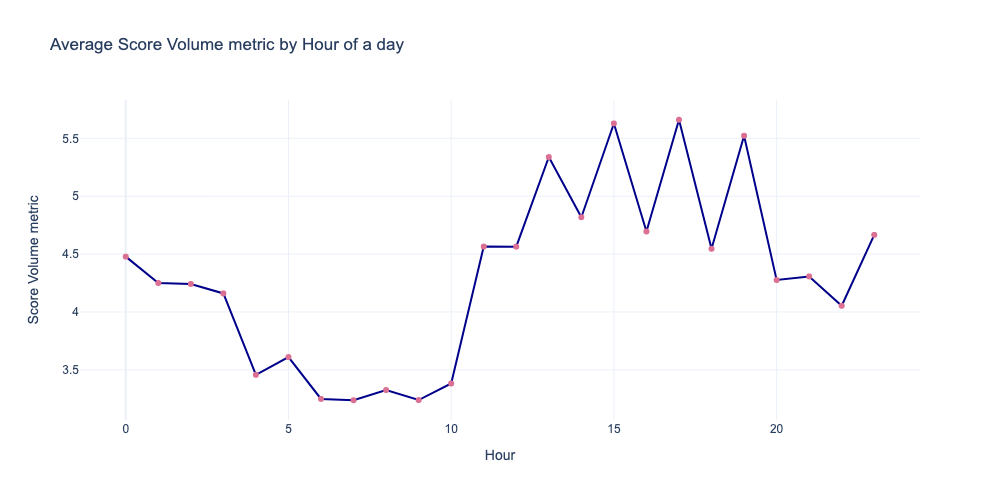

In [16]:
df_tweet['hour'] = df_tweet['date'].dt.hour
df_grouped = df_tweet.groupby('hour', as_index=False)['score_volume_metrics'].mean()

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_grouped['hour'], y=df_grouped['score_volume_metrics'],
                         mode='lines+markers',
                         name='score_volume_metrics',
                         line=dict(color='darkblue', width=2),
                         marker=dict(size=6, color='palevioletred')))

fig.update_layout(
    title='Average Score Volume metric by Hour of a day',
    xaxis_title='Hour',
    yaxis_title='Score Volume metric',
    width=1000,
    height=500,
)

fig.show("png")


### Cumulative Volume since Start of the Day (Tweets number, Retweets, Replies, Likes, Unique Users)

In [17]:
df_tweet["feature_cum_sum_tweet_count"]   = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).cumcount() + 1
df_tweet["feature_cum_sum_retweet_count"] = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)])['feature_retweets_count'].cumsum()
df_tweet["feature_cum_sum_likes_count"]   = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)])['feature_likes_count'].cumsum()
df_tweet["feature_cum_sum_replies_count"] = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)])['feature_replies_count'].cumsum()

df_tweet["feature_cum_sum_unique_user_count"] = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ), "user_id"], as_index=False).cumcount() + 1

In [18]:
corr_cumsum_tweet   = abs(df_tweet['close'].corr(df_tweet["feature_cum_sum_tweet_count"]))
corr_cumsum_retweet = abs(df_tweet['close'].corr(df_tweet["feature_cum_sum_retweet_count"]))
corr_cumsum_likes   = abs(df_tweet['close'].corr(df_tweet["feature_cum_sum_likes_count"]))
corr_cumsum_replies = abs(df_tweet['close'].corr(df_tweet["feature_cum_sum_replies_count"]))
corr_cumsum_unique_user = abs(df_tweet['close'].corr(df_tweet["feature_cum_sum_unique_user_count"]))

corr_cumsum_tweet, corr_cumsum_retweet, corr_cumsum_likes, corr_cumsum_replies, corr_cumsum_unique_user

(0.23620226429165075,
 0.34769467224179446,
 0.4741987769580011,
 0.3368967021486013,
 0.0009854164416936225)

In [19]:
volume_corr_cum_metrics = corr_cumsum_tweet + corr_cumsum_retweet + corr_cumsum_likes + corr_cumsum_replies + corr_cumsum_unique_user

w_cumsum_tweet   = corr_cumsum_tweet / volume_corr_cum_metrics
w_cumsum_retweet = corr_cumsum_retweet / volume_corr_cum_metrics
w_cumsum_likes   = corr_cumsum_likes / volume_corr_cum_metrics
w_cumsum_replies = corr_cumsum_replies / volume_corr_cum_metrics
w_cumsum_unique_user = corr_cumsum_unique_user / volume_corr_cum_metrics

w_cumsum_tweet, w_cumsum_retweet, w_cumsum_likes, w_cumsum_replies, w_cumsum_unique_user

(0.16920201658175038,
 0.2490689065766162,
 0.3396893317788978,
 0.24133384815015768,
 0.0007058969125778507)

In [20]:
def volume_score_cum_metrics(cumsum_tweet, cumsum_retweet, cumsum_likes, cumsum_replies, cum_unique_user):
    return cumsum_tweet * w_cumsum_tweet + cumsum_retweet * w_cumsum_retweet + cumsum_likes * w_cumsum_likes + cumsum_replies * w_cumsum_replies + cum_unique_user * w_cumsum_unique_user

In [21]:
df_tweet['score_volume_cum_metrics'] = df_tweet.apply(lambda x: volume_score_cum_metrics(x['feature_cum_sum_tweet_count'], x['feature_cum_sum_retweet_count'], x['feature_cum_sum_likes_count'], x['feature_cum_sum_replies_count'], x['feature_cum_sum_unique_user_count']), axis=1)

Correlation between OCEAN price and Cumulative Volume Tweet metric, it will used as a weight for the key factor Volume score

In [22]:
df_tweet_cum_volume_metrics = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).agg({'score_volume_cum_metrics':'mean', 'close':'last'})
corr_cum_metrics = abs(df_tweet_cum_volume_metrics['score_volume_cum_metrics'].corr(df_tweet_cum_volume_metrics['close']))
corr_cum_metrics

0.5850388245604771

### Total Day Metrics Volume

In [23]:
tmp_feature_total_tweet_count = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)]).size()
tmp_feature_total_tweet_count = tmp_feature_total_tweet_count.reset_index(name='feature_total_tweet_count')
df_tweet = pd.merge_asof(df_tweet.sort_values('date'), tmp_feature_total_tweet_count.sort_values('date'), on='date')

tmp_feature_total_retweet_count = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)])['retweets_count'].sum()
tmp_feature_total_retweet_count = tmp_feature_total_retweet_count.reset_index(name='feature_total_retweet_count')
df_tweet = pd.merge_asof(df_tweet.sort_values('date'), tmp_feature_total_retweet_count.sort_values('date'), on='date')

tmp_feature_total_likes_count = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)])['likes_count'].sum()
tmp_feature_total_likes_count = tmp_feature_total_likes_count.reset_index(name='feature_total_likes_count')
df_tweet = pd.merge_asof(df_tweet.sort_values('date'), tmp_feature_total_likes_count.sort_values('date'), on='date')

tmp_feature_total_replies_count = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)])['replies_count'].sum()
tmp_feature_total_replies_count = tmp_feature_total_replies_count.reset_index(name='feature_total_replies_count')
df_tweet = pd.merge_asof(df_tweet.sort_values('date'), tmp_feature_total_replies_count.sort_values('date'), on='date')

tmp_feature_total_unique_user_count = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ), "user_id"]).size()
tmp_feature_total_unique_user_count = tmp_feature_total_unique_user_count.reset_index(name='feature_total_unique_user_count')
df_tweet = pd.merge_asof(df_tweet.sort_values('date'), tmp_feature_total_unique_user_count.sort_values('date'), on='date', by='user_id')

In [24]:
corr_total_tweet   = abs(df_tweet['close'].corr(df_tweet["feature_total_tweet_count"]))
corr_total_retweet = abs(df_tweet['close'].corr(df_tweet["feature_total_retweet_count"]))
corr_total_likes   = abs(df_tweet['close'].corr(df_tweet["feature_total_likes_count"]))
corr_total_replies = abs(df_tweet['close'].corr(df_tweet["feature_total_replies_count"]))
corr_total_unique_user = abs(df_tweet['close'].corr(df_tweet["feature_total_unique_user_count"]))

corr_total_tweet, corr_total_retweet, corr_total_likes, corr_total_replies, corr_total_unique_user

(0.33210519031388847,
 0.46316445119165633,
 0.6177640023855114,
 0.4616614845559772,
 2.8653908499325132e-05)

In [25]:
volume_corr_total_metrics = corr_total_tweet + corr_total_retweet + corr_total_likes + corr_total_replies + corr_total_unique_user

w_total_tweet   = corr_total_tweet / volume_corr_total_metrics
w_total_retweet = corr_total_retweet / volume_corr_total_metrics
w_total_likes   = corr_total_likes / volume_corr_total_metrics
w_total_replies = corr_total_replies / volume_corr_total_metrics
w_total_unique_user = corr_total_unique_user / volume_corr_total_metrics

w_total_tweet, w_total_retweet, w_total_likes, w_total_replies, w_total_unique_user

(0.17714886504325908,
 0.24705743616785214,
 0.3295226785939153,
 0.2462557358588121,
 1.5284336161417006e-05)

In [26]:
def volume_score_total_metrics(total_tweet, total_retweet, total_likes, total_replies, cum_unique_user):
    return total_tweet * w_total_tweet + total_retweet * w_total_retweet + total_likes * w_total_likes + total_replies * w_total_replies + cum_unique_user * w_total_unique_user

In [27]:
df_tweet['score_volume_total_metrics'] = df_tweet.apply(lambda x: volume_score_cum_metrics(x['feature_total_tweet_count'], x['feature_total_retweet_count'], x['feature_total_likes_count'], x['feature_total_replies_count'], x['feature_total_unique_user_count']), axis=1)

In [28]:
df_tweet_total_volume_metrics = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).agg({'score_volume_total_metrics':'mean', 'close':'last'})
corr_total_metrics = abs(df_tweet_total_volume_metrics['score_volume_total_metrics'].corr(df_tweet_total_volume_metrics['close']))
corr_total_metrics

0.5869398106688326

### Volume score creation
Creation of the weights thanks to the calculation of previous features correlation

In [29]:
volume_corr = corr_metrics + corr_cum_metrics + corr_total_metrics

w_cum_metrics = corr_cum_metrics / volume_corr
w_metrics     = corr_metrics / volume_corr
w_total       = corr_total_metrics / volume_corr

w_cum_metrics, w_metrics, w_total

(0.3424745930702026, 0.3139379997751957, 0.3435874071546017)

In [30]:
def volume_score(metrics, cum_metrics, total_metrics):
    return w_metrics * metrics + w_cum_metrics * cum_metrics + w_total * total_metrics

In [31]:
df_tweet['score_volume'] = df_tweet.apply(lambda x: volume_score(x['score_volume_metrics'], x['score_volume_cum_metrics'], x['score_volume_total_metrics']), axis=1)

In [32]:
df_tweet_volume = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).agg({'score_volume':'mean', 'close':'last'})
corr_score_volume = abs(df_tweet_volume['score_volume'].corr(df_tweet_volume['close']))
corr_score_volume

0.5886592795927285

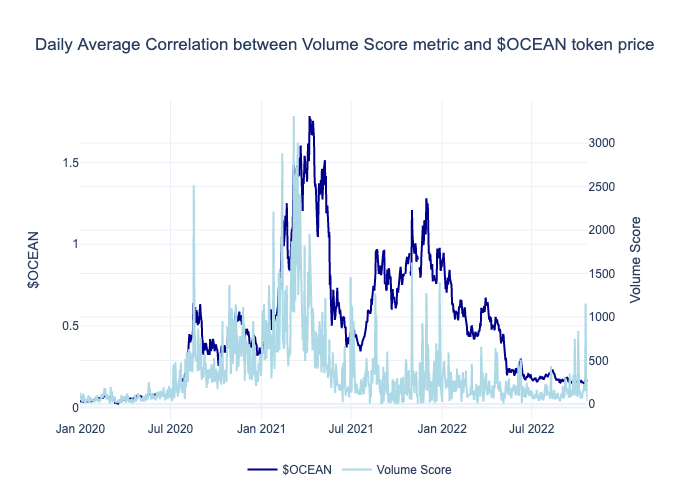

In [33]:
fig = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_tweet_volume['date'], y=df_tweet_volume['close'],
                         mode='lines',
                         name='$OCEAN',
                         line=dict(color='darkblue', width=2)),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_tweet_volume['date'], y=df_tweet_volume['score_volume'],
                         mode='lines',
                         name='Volume Score',
                         line=dict(color='lightblue', width=2)),
              secondary_y=True, row=1, col=1)

fig.update_layout(
    title='Daily Average Correlation between Volume Score metric and $OCEAN token price',
    yaxis_title='$OCEAN',
    height=500,  # Adjusted for two subplots
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.2,
        xanchor='center',
        x=0.5
    )
)

fig.update_yaxes(title_text="Volume Score", secondary_y=True, row=1, col=1)

fig.show("png")

## User Influence

In [34]:
df_tweet_monthly      = df_tweet.groupby([pd.Grouper(key='date', freq='M')], as_index=False).agg({'feature_likes_count': 'sum', 'feature_retweets_count': 'sum', 'feature_replies_count': 'sum', 'tweet':'count', 'close':'last'})
df_tweet_monthly_user = df_tweet.groupby([pd.Grouper(key='date', freq='M'), "user_id"], as_index=False).agg({'feature_likes_count': 'sum', 'feature_retweets_count': 'sum', 'feature_replies_count': 'sum', 'tweet':'count', 'close':'last'})

In [35]:
corr_likes_user    = abs(df_tweet_monthly['feature_likes_count'].corr(df_tweet_monthly['close']))
corr_retweets_user = abs(df_tweet_monthly['feature_retweets_count'].corr(df_tweet_monthly['close']))
corr_replies_user  = abs(df_tweet_monthly['feature_replies_count'].corr(df_tweet_monthly['close']))
corr_tweet_count_user = abs(df_tweet_monthly['tweet'].corr(df_tweet_monthly['close']))

corr_likes_user, corr_retweets_user, corr_replies_user, corr_tweet_count_user

(0.7176241611055468,
 0.6670399325123035,
 0.6795223906633152,
 0.5320082494455453)

In [36]:
user_corr = corr_likes_user + corr_retweets_user + corr_replies_user + corr_tweet_count_user

w_replies_user  = corr_replies_user / user_corr
w_retweets_user = corr_retweets_user / user_corr
w_likes_user    = corr_likes_user / user_corr
w_tweet_count_user = corr_tweet_count_user / user_corr

w_likes_user, w_retweets_user, w_replies_user, w_tweet_count_user

(0.2764138420677837,
 0.2569298534685802,
 0.2617378357007504,
 0.20491846876288564)

In [37]:
def influence_score(replies, retweets, likes, tweet_count):
    return replies * w_replies_user + retweets * w_retweets_user + likes * w_likes_user + tweet_count * w_tweet_count_user

Assign to each user an Influence score that is updated every month

In [38]:
df_tweet_monthly_user['score_influence'] = df_tweet_monthly_user.apply(lambda x: influence_score(x['feature_replies_count'], x['feature_retweets_count'], x['feature_likes_count'], x['tweet']), axis=1)

In [39]:
df_tweet = pd.merge_asof(df_tweet, df_tweet_monthly_user[['date', 'user_id', 'score_influence']], on='date', by='user_id', direction='nearest')

In [40]:
df_tweet_influence = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).agg({'score_influence':'mean', 'close':'last'})
corr_score_influence = abs(df_tweet_influence['score_influence'].corr(df_tweet_influence['close']))
corr_score_influence

0.5440841133478966

In [41]:
df_tweet_influence_user = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ), 'username'], as_index=False).agg({'score_influence':'mean', 'close':'last'})

In [42]:
df_grouped = df_tweet_influence_user.groupby('username').filter(lambda x: len(x) > 8)
df_top_20_influencers = df_grouped.groupby('username', as_index=False)['score_influence'].mean().sort_values('score_influence').tail(20)

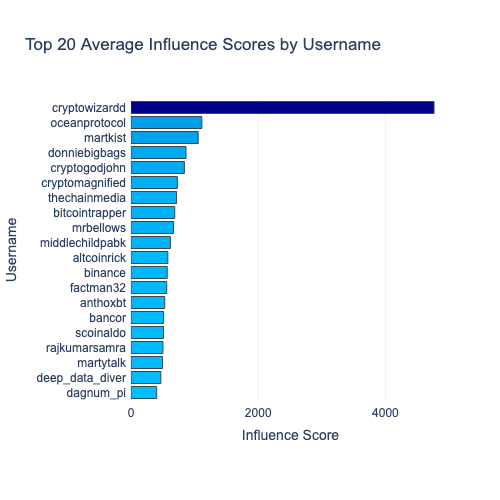

In [43]:
fig = go.Figure()

# Normalize score to range between 0 and 1 for color mapping
normalized_score = (df_top_20_influencers['score_influence'] - df_top_20_influencers['score_influence'].min()) / (df_top_20_influencers['score_influence'].max() - df_top_20_influencers['score_influence'].min())

colors = []

for norm_score in normalized_score:
    # Linear interpolation of the RGB components
    interp_color = [int((1 - norm_score) * 0 + norm_score * 0),  # Red component
                    int((1 - norm_score) * 191 + norm_score * 0),  # Green component
                    int((1 - norm_score) * 255 + norm_score * 139)]  # Blue component
    colors.append('rgb({},{},{})'.format(*interp_color))

for i, user in enumerate(df_top_20_influencers['username']):
    fig.add_trace(go.Bar(
        y=[user],
        x=[df_top_20_influencers['score_influence'].iloc[i]],
        name=user,
        orientation='h',
        marker=dict(
            color=colors[i],
            line=dict(color='rgb(58, 71, 80)', width=1)
        )
    ))

fig.update_layout(
    title='Top 20 Average Influence Scores by Username',
    xaxis_title='Influence Score',
    yaxis_title='Username',
    yaxis={'categoryorder':'total ascending'},  # Optional: this sorts the bars by total score
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    showlegend=False
)

fig.show("png")


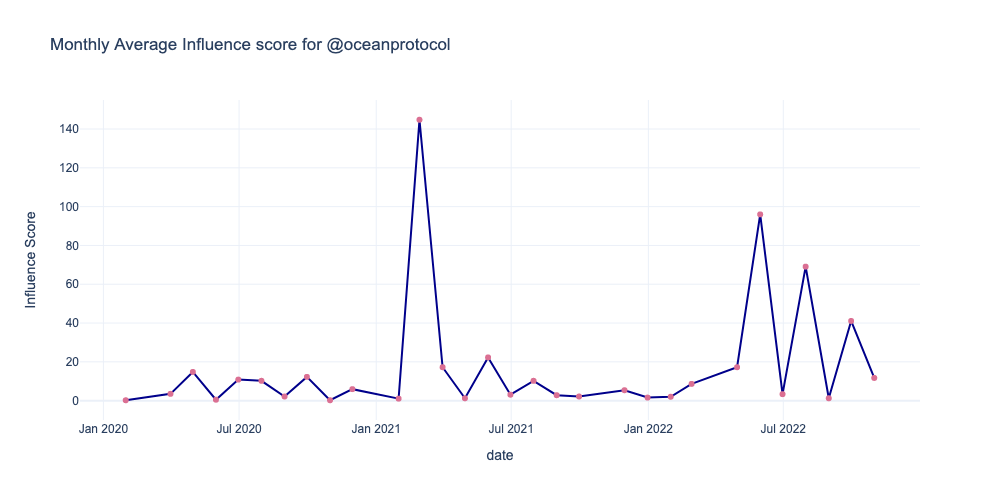

In [44]:
fig = go.Figure()

df_tweet_influence_oceanprotocol = df_tweet.groupby([pd.Grouper(key='date', freq='M'), 'username'], as_index=False).agg({'score_influence':'mean', 'close':'last'})
user_df = df_tweet_influence_oceanprotocol[df_tweet_influence_oceanprotocol['username'] == 'oceanprotocol']

fig.add_trace(go.Scatter(x=user_df['date'], y=df_grouped['score_influence'],
                         mode='lines+markers',
                         name='Influence Score',
                         line=dict(color='darkblue', width=2),
                         marker=dict(size=6, color='palevioletred')))

# Edit the layout
fig.update_layout(
    title='Monthly Average Influence score for @oceanprotocol',
    xaxis_title='date',
    yaxis_title='Influence Score',
    width=1000,
    height=500,
)

fig.show("png")

# Sentiment
## Crypto Fear & Greed Index
alternative API call

In [45]:
# Making the API request
response = requests.get("https://api.alternative.me/fng/?limit=1000000")

# Checking if the request was successful
if response.status_code == 200:
    data = response.json()

    df_fg = pd.json_normalize(data['data']) 
    df_fg['timestamp'] = pd.to_datetime(df_fg['timestamp'], unit='s')
    df_fg.sort_values(by="timestamp", inplace=True)
    df_fg['value'] = df_fg['value'].astype(float)

else:
    print(f"Request failed with status code {response.status_code}")


Shift one day because this score is calculated based on the last day

In [46]:
df_fg[['value', 'value_classification']] = df_fg[['value', 'value_classification']].shift(-1)

In [47]:
df_tweet = pd.merge_asof(df_tweet, df_fg[['timestamp', 'value']], left_on='date', right_on='timestamp')

In [48]:
df_tweet['feature_fg'] = df_tweet['value'] / 100

def normalize_to_neg1_pos1(x):
    return 2 * x - 1

df_tweet['feature_fg'] = df_tweet['feature_fg'].apply(normalize_to_neg1_pos1)

In [49]:
df_tweet_fg = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).agg({'feature_fg':'mean', 'close':'last'})
corr_fg = abs(df_tweet_fg['feature_fg'].corr(df_tweet_fg['close']))
corr_fg

0.3920883014370171

## Vader

In [50]:
NEG_CONTRACTIONS = {'ain':"ain't", 'aren':"are not", 'couldn':"could not",  'didn':"did not", 'doesn':"does not", 'hadn':"had not", 'hasn':"has not", 'haven':"have not", 'isn':"is not", 'mightn':"might not", 'mustn':"must not", 'needn':"need not", 'shan':"shall not", 'shouldn':"should not", 'wasn':"was not", 'weren':"were not", 'wouldn':"would not"}
ACRONYMS         = {'pls':'please', 'fsb':'federal security bureau', '₿itcoin':'bitcoin', 'mp':'member of parliament', 'bayc':'bored ape yacht club', 'usa':'united states of america', 'fca':'financial conduct authorithy', 'fcc':'federal communications commission', 'tvl':'total value locked', 'fdic':'federal deposit insurance corporation', 'doj':'departement of justice', 'ftc':'federal trade commission', 'cftc':'commodity futures trading commission', 'fomo':'fear of missing out', 'fud':'fear uncertainty doubt', 'kyc':'know your customer', 'hodlers':'holders', 'hodler':'holder', 'hodl':'hold', 'ito':'initial token offering', 'ico':'initial coin offering', 'dex':'decentralized exchange', 'ln':' lightning network', 'macd':'moving average convergence divergence', 'erc':'ethereum request for comments', 'eip':'ethereum improvement proposal', 'daos':'decentralized autonomous organization', 'dao':'decentralized autonomous organization', 'pow':'proof of work', 'ytd':'year to date', 'ath':'all time high', 'cpi':'consumer price index', 'ecb':'european central bank', 'fed':'federal reserve', 'lbma':'london bullion market association', 'fbi':'federal bureau of investigation', 'imf':'international monetary fund', 'ether':'ethereum', 'btcs':'bitcoins', 'eth':'ethereum', 'btc':'bitcoin', 'sec':'securities and exchange commission', 'ceo':'chief executive officer', 'etf':'exchange traded fund', 'uk':'united kingdom', 'defi':'decentralized finance', 'eu':'european union','nfts':'non fungible token', 'nft':'non fungible token', 'cbdcs':'central bank digital currency', 'cbdc':'central bank digital currency'}
UPPER_ACRONYMS   = {'USA':'united states of america', 'US':'united states', 'EU':'european union', 'U.S.':'united states', 'E.U.':'european union'}

Helpers functions that will be usefull in the tweet pre-processing

In [51]:
# Take words in the # that are English --> #BTC #PUMP --> PUMP
def english_word_hastag(s):
    hashtag_words = re.findall(r"#(\w+)", s)
    result = map((lambda word: '#' + word), hashtag_words)
    result = sorted(result, key=len, reverse=True)
    if len(result) != 0:
        result = "|".join(result)
        hashtag_pattern = re.compile("("+result+")\S*")
        s = hashtag_pattern.sub(r' ', s)
    return s

def remove_hashtag_series(text):
    index_to_remove = []

    words = text.split()
    hastag_words_index = []
    for i in range(len(words)):
        if '#' in words[i]:
            hastag_words_index.append(i)

    if len(hastag_words_index) > 1:
        for j in range(len(hastag_words_index)):
            if j == 0:
                continue
            if (hastag_words_index[j-1] + 1) == hastag_words_index[j]:
                index_to_remove.append(hastag_words_index[j-1])
            if (hastag_words_index[j-1]) == hastag_words_index[j] - 1:
                index_to_remove.append(hastag_words_index[j])
            if j == (len(hastag_words_index)-1) and (hastag_words_index[j-1] + 1) == hastag_words_index[j]:
                index_to_remove.append(hastag_words_index[j])

    index_to_remove = sorted(list(dict.fromkeys(index_to_remove)), reverse=True)
    for idx in index_to_remove:
        if idx < len(words):
            words.pop(idx)
    return " ".join(words)

def remove_consecutive_words(text):
    text = ' '.join(k for k, _ in itertools.groupby(text.split()))
    return text

def manage_contractions(s):
    tokens = s.split()
    tokens = [NEG_CONTRACTIONS[e] if e in NEG_CONTRACTIONS else e for e in tokens]
    tokens = [e.split() for e in tokens]
    tokens = [item for sublist in tokens for item in sublist]
    result = map((lambda x: contractions.fix(x)), tokens)
    return " ".join(result)

def manage_acronyms(s, acronyms):
    tokens = s.split()
    tokens = [acronyms[e] if e in acronyms else e for e in tokens]
    return " ".join(tokens)

lemma = WordNetLemmatizer()

# STOPWORDS = ['the','to','and','is','in','of','on','for','it','you','this','with','will','are','be','that','all','my','at','more','now','your','we','have','up','can','just','if','martkist','what','from','but','like','by','some','out','ha','next','one']

def lemmatization_stopwords_management(text):
    text_tokens = word_tokenize(text)
    # text_tokens = [word for word in text_tokens if not word in STOPWORDS]
    # text_tokens = [lemma.lemmatize(word) for word in text_tokens]
    if len(text_tokens) > 0:
        last_word   = text_tokens[-1]
        if  last_word == 'read' or last_word == 'via':
            text_tokens = text_tokens[:-1]
    return (" ").join(text_tokens)

In [52]:
def clean_tweet(df):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
                                              
    df["clean_tweet"] = df['tweet'].str.replace(emoji_pattern, ' ', regex=True)
    df["clean_tweet"] = df.apply(lambda x: manage_acronyms(x.clean_tweet, UPPER_ACRONYMS), axis=1)
    df["clean_tweet"] = df["clean_tweet"].str.lower()
    df["clean_tweet"] = df['clean_tweet'].str.replace(r"(\S)(#)", r"\1 \2", regex=True) # add space between #
    df["clean_tweet"] = df['clean_tweet'].str.replace('(?:\$|\@|https?\://)\S+|www\.\S+', ' ', regex=True) # remove ticker $, @name, links
    df["clean_tweet"] = df['clean_tweet'].str.replace(r"(.)(\1{1})(\1+)", r"\1\2", regex=True) # remove repeated character : heeelloooo-> heelloo
    df["clean_tweet"] = df.apply(lambda x: remove_hashtag_series(x.clean_tweet), axis=1)
    df["clean_tweet"] = df.apply(lambda x: english_word_hastag(x.clean_tweet), axis=1)
    df["clean_tweet"] = df['clean_tweet'].str.replace('&\w+;', ' ', regex=True)
    df["clean_tweet"] = df['clean_tweet'].str.replace('\[.*?\]', ' ', regex=True)
    df["clean_tweet"] = df['clean_tweet'].str.replace('<.*?>+', ' ', regex=True)
    df["clean_tweet"] = df['clean_tweet'].str.replace("[-—'’']", ' ', regex=True)
    # df["clean_tweet"] = df['clean_tweet'].str.replace('[%s]' % re.escape(string.punctuation), ' ', regex=True)
    df["clean_tweet"] = df['clean_tweet'].str.replace("[¡“’”►—🟧‘…•̇̇̇',․⏲​​⏰⁦––⏱‼⏫∞]", ' ', regex=True)
    df["clean_tweet"] = df['clean_tweet'].str.replace('\n', ' ', regex=True)
    df["clean_tweet"] = df['clean_tweet'].str.replace('\d', ' ', regex=True)
    df["clean_tweet"] = df.apply(lambda x: manage_contractions(x.clean_tweet), axis=1)
    df["clean_tweet"] = df.apply(lambda x: manage_acronyms(x.clean_tweet, ACRONYMS), axis=1)
    df["clean_tweet"] = df.apply(lambda x: lemmatization_stopwords_management(x.clean_tweet), axis=1)
    df["clean_tweet"] = df['clean_tweet'].str.replace(r"(^| ).(( ).)*( |$)", r' ', regex=True) # remove single character
    df["clean_tweet"] = df['clean_tweet'].str.strip()
    df["clean_tweet"] = df.apply(lambda x: remove_consecutive_words(x.clean_tweet), axis=1) # remove same consecutive words, buy buy buy -> buy
    df["clean_tweet"] = df['clean_tweet'].str.replace(r' +', r' ', regex=True)
    df['split_clean_tweet'] = df['clean_tweet'].str.split()
    df = df[df['split_clean_tweet'].str.len() >= 4]
    return df

In [53]:
df_tweet = clean_tweet(df_tweet)

In [54]:
def generate_sentiment_score(sentiments, tool):
    if tool == 'vader':
        sentiment_values = {'neg': -1, 'neu': 0, 'pos': 1, 'compound': 0}
    overall_score = sum([sentiment_values[k] * v for k, v in sentiments.items()])

    return overall_score

In [55]:
sid_obj = SentimentIntensityAnalyzer()

def get_sentiment_score_vader(text):
    # Get Sentiment + Coumpound
    sentiment_dict = sid_obj.polarity_scores(text)

    sentiment_score = generate_sentiment_score(sentiment_dict, tool='vader')
    compound = sentiment_dict['compound']
    return sentiment_score, compound

In [56]:
df_tweet[['vader', 'vader_compound']] = df_tweet.apply(lambda x: get_sentiment_score_vader(x['clean_tweet']), axis=1, result_type='expand')
df_tweet['feature_vader'] = (df_tweet['vader'] + df_tweet['vader_compound']) / 2

In [57]:
df_tweet_vader = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).agg({'vader':'mean', 'close':'last'})
abs(df_tweet_vader['vader'].corr(df_tweet_vader['close']))

0.007592810442014085

In [58]:
df_tweet_vader_compound= df_tweet.groupby([pd.Grouper(key='date',freq=FREQ)], as_index=False).agg({'vader_compound':'mean', 'close':'last'})
abs(df_tweet_vader_compound['vader_compound'].corr(df_tweet_vader_compound['close']))

6.973203322106495e-05

In [59]:
df_tweet_vader_score = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).agg({'feature_vader':'mean', 'close':'last'})
corr_vader = abs(df_tweet_vader_score['feature_vader'].corr(df_tweet_vader_score['close']))
corr_vader

0.0026706834421598535

## TextBlob

In [60]:
def get_sentiment_score_textblob(text):
    sentiments = TextBlob(text)

    return sentiments.sentiment.polarity, sentiments.sentiment.subjectivity

In [61]:
df_tweet[['textblob_polarity', 'textblob_subjectivity']] = df_tweet.apply(lambda x: get_sentiment_score_textblob(x['clean_tweet']), axis=1, result_type='expand')

In [62]:
df_tweet_textblob_polarity= df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).agg({'textblob_polarity':'mean', 'close':'last'})
textblob_polarity = abs(df_tweet_textblob_polarity['textblob_polarity'].corr(df_tweet_textblob_polarity['close']))
textblob_polarity

0.08911491001291678

In [63]:
df_tweet_textblob_subjectivity = df_tweet.groupby([pd.Grouper(key='date',freq=FREQ)], as_index=False).agg({'textblob_subjectivity':'mean', 'close':'last'})
textblob_subjectivity = abs(df_tweet_textblob_subjectivity['textblob_subjectivity'].corr(df_tweet_textblob_subjectivity['close']))
textblob_subjectivity

0.04642636157326122

Multiply Polarity & Subjectivity to have a real sentiment of the tweet

In [64]:
df_tweet['feature_textblob'] = df_tweet['textblob_polarity'] * df_tweet['textblob_subjectivity']

In [65]:
df_tweet_textblob = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).agg({'feature_textblob':'mean', 'close':'last'})
corr_textblob = abs(df_tweet_textblob['feature_textblob'].corr(df_tweet_textblob['close']))
corr_textblob

0.08865387204651953

In [66]:
corr_fg, corr_textblob, corr_vader

(0.3920883014370171, 0.08865387204651953, 0.0026706834421598535)

In [67]:
sentiment_corr = corr_fg + corr_textblob + corr_vader
w_fg = corr_fg / sentiment_corr
w_textblob = corr_textblob / sentiment_corr
w_vader = corr_vader / sentiment_corr

w_fg, w_textblob, w_vader

(0.8110837265076785, 0.18339163052120927, 0.005524642971112275)

In [68]:
def sentiment_score(fg, textblob, vader):
    return fg * w_fg + w_textblob * textblob + w_vader * vader

In [69]:
df_tweet['score_sentiment'] = df_tweet.apply(lambda x: sentiment_score(x['feature_fg'], x['feature_textblob'], x['feature_vader']), axis=1)

In [70]:
df_tweet_sentiment = df_tweet.groupby([pd.Grouper(key='date', freq=FREQ)], as_index=False).agg({'score_sentiment':'mean', 'close':'last'})
corr_score_sentiment = abs(df_tweet_sentiment['score_sentiment'].corr(df_tweet['close']))
corr_score_sentiment

0.4886722361354741

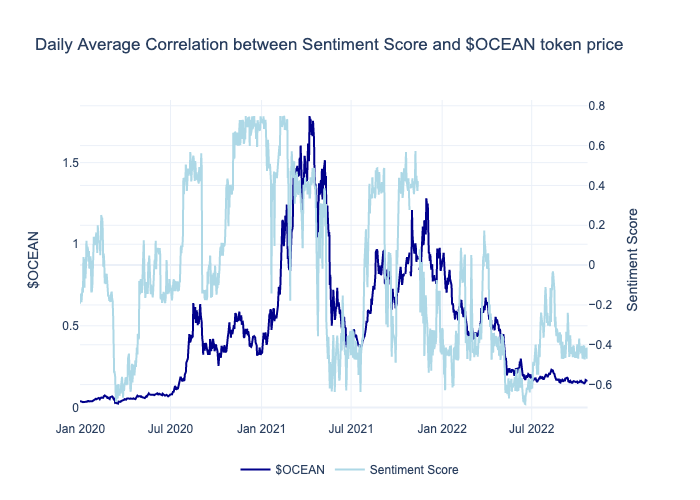

In [71]:
fig = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_tweet_sentiment['date'], y=df_tweet_sentiment['close'],
                         mode='lines',
                         name='$OCEAN',
                         line=dict(color='darkblue', width=2)),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_tweet_sentiment['date'], y=df_tweet_sentiment['score_sentiment'],
                         mode='lines',
                         name='Sentiment Score',
                         line=dict(color='lightblue', width=2)),
              secondary_y=True, row=1, col=1)

fig.update_layout(
    title='Daily Average Correlation between Sentiment Score and $OCEAN token price',
    yaxis_title='$OCEAN',
    height=500,  # Adjusted for two subplots
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.2,
        xanchor='center',
        x=0.5
    )
)

fig.update_yaxes(title_text="Sentiment Score", secondary_y=True, row=1, col=1)

fig.show("png")

### Most positive Tweet base only on the sentiment

In [72]:
df_tweet[df_tweet['score_sentiment'] == df_tweet['score_sentiment'].max()]['tweet'].values[0], df_tweet['score_sentiment'].max()

('Awesome videos as always @QuintenFrancois. $grt $rsr $ocean  https://t.co/pYmac9dcKT',
 0.9166870185716097)

### Most negative Tweet base only on the sentiment

In [73]:
df_tweet[df_tweet['score_sentiment'] == df_tweet['score_sentiment'].min()]['tweet'].values[0], df_tweet['score_sentiment'].min()

('When they say "Buy when others are fearful", does that include yourself? 😨  $BTC $ETH $OCEAN $VET $TOMO $TFD $ENJ $ICX $DAG #crypto',
 -0.8482740479713944)

## Impact Score

Normalization of Volume & Influence score between 0 and 1

In [74]:
scaler = MinMaxScaler(feature_range=(0, 1))

values_volume = df_tweet['score_volume'].values.reshape(-1, 1)
# fit and transform the data
df_tweet['score_volume'] = scaler.fit_transform(values_volume)

values_influence = df_tweet['score_influence'].values.reshape(-1, 1)
# fit and transform the data
df_tweet['score_influence'] = scaler.fit_transform(values_influence)

In [75]:
df_tweet_all = df_tweet.groupby([pd.Grouper(key='date', freq='4H')], as_index=False).agg({'score_sentiment':'mean', 'score_influence':'mean', 'score_volume':'mean', 'close':'last'})

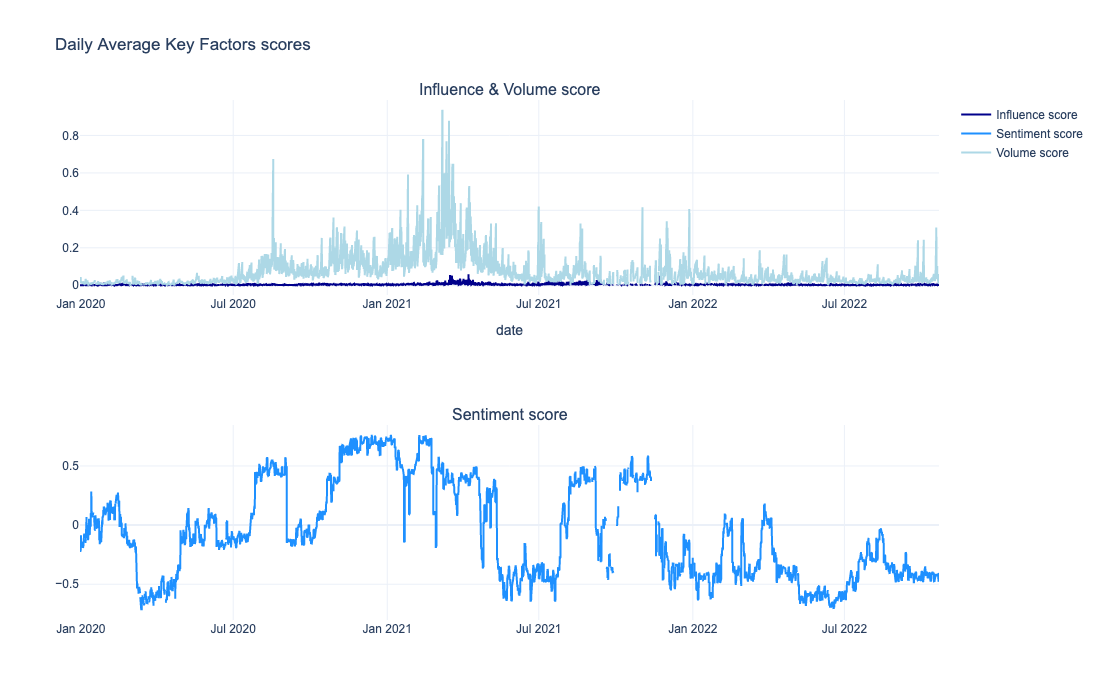

In [76]:
fig = make_subplots(rows=2, cols=1, subplot_titles=('Influence & Volume score', 'Sentiment score'))

# Add traces
fig.add_trace(go.Scatter(x=df_tweet_all['date'], y=df_tweet_all['score_influence'],
                         mode='lines',
                         name='Influence score',
                         line=dict(color='darkblue', width=2, backoff=0.7)),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_tweet_all['date'], y=df_tweet_all['score_sentiment'],
                         mode='lines',
                         name='Sentiment score',
                         line=dict(color='dodgerblue', width=2, backoff=0.7)),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_tweet_all['date'], y=df_tweet_all['score_volume'],
                         mode='lines',
                         name='Volume score',
                         line=dict(color='lightblue', width=2, backoff=0.7)),
              row=1, col=1)

# Edit the layout
fig.update_layout(
    title='Daily Average Key Factors scores',
    xaxis_title='date',
    autosize=False,
    width=1100,
    height=700,
)


fig.show("png")

In [77]:
impact_corr = corr_score_volume + corr_score_influence 

w_volume    = corr_score_volume / impact_corr
w_influence = corr_score_influence / impact_corr

w_volume, w_influence

(0.5196757564522685, 0.4803242435477316)

The impact score is preferred to the price change score. So the sentiment impact score is based more on social networks than the price change score.

In [78]:
w_impact = 0.665
w_change = 0.335

Impact Sentiment score creation (Target) 

In [79]:
def impact_score(volume, influence, sentiment, change):
    return ((w_volume * volume + w_influence * influence ) * sentiment) * w_impact + (change * w_change)

def granger_impact_score(volume, influence, sentiment):
    return (w_volume * volume + w_influence * influence) * sentiment

In [80]:
df_tweet['impact_score'] = df_tweet.apply(lambda x: impact_score(x['score_volume'], x['score_influence'], x['score_sentiment'], x['4h_change']), axis=1)

In [81]:
df_tweet['granger_impact_score'] = df_tweet.apply(lambda x: granger_impact_score(x['score_volume'], x['score_influence'], x['score_sentiment']), axis=1)

In [82]:
df_tweet['year'] = df_tweet['date'].dt.year
df_tweet['month'] = df_tweet['date'].dt.month
df_tweet_grouped = df_tweet.groupby(['year', 'month'])['impact_score'].mean().reset_index()

In [83]:
df_pivot = df_tweet_grouped.pivot(index='month', columns='year', values='impact_score')
df_grouped2 = df_tweet.groupby(['year', 'month'])['close'].last().reset_index()
df_pivot2 = df_grouped2.pivot(index='month', columns='year', values='close')

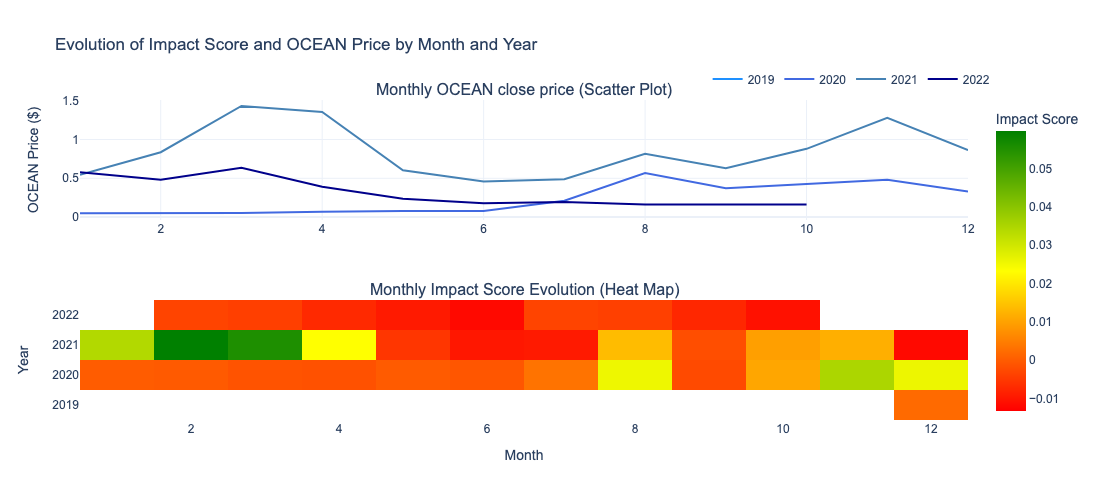

In [84]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Define custom colorscale "Red to Green"
colorscale = [[0, 'white'], [0.0001, 'red'], [0.5, 'yellow'], [1, 'green']]

# Replace NaN values with a special value
df_pivot.fillna(-1, inplace=True)

fig = make_subplots(rows=2, cols=1, subplot_titles=('Monthly OCEAN close price (Scatter Plot)', 'Monthly Impact Score Evolution (Heat Map)'))

# Colors for different years
color_dict = {2019: 'dodgerblue', 2020: 'royalblue', 2021: 'steelblue', 2022: 'darkblue'}

# Adding the scatter plot on top
for year in df_pivot2.columns:
    fig.add_trace(
        go.Scatter(x=df_pivot2.index, y=df_pivot2[year], mode='lines', name=str(year), legendgroup=str(year), hovertemplate='Year: '+str(year)+'<br>Month: %{x}<br>Value: %{y}',
                   line=dict(color=color_dict[year], width=2)),
        row=1, col=1
    )

# Adding the heatmap at the bottom
fig.add_trace(
    go.Heatmap(
        z=df_pivot.values.T,  # Transpose to swap x and y
        y=df_pivot.columns,
        x=df_pivot.index,
        colorscale=colorscale,
        zmin=df_tweet_grouped['impact_score'].min(), zmax=df_tweet_grouped['impact_score'].max(),
        colorbar=dict(title='Impact Score'),
        hovertemplate='Year: %{y}<br>Month: %{x}<br>Value: %{z}'
    ),
    row=2, col=1
)

fig.update_layout(
    title='Evolution of Impact Score and OCEAN Price by Month and Year',
    width=1100,
    height=500,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1.03)
)

fig.update_xaxes(title_text="Month", row=2, col=1)
fig.update_yaxes(title_text="Year", row=2, col=1)
fig.update_yaxes(title_text="OCEAN Price ($)", row=1, col=1)

fig.show("png")


In [85]:
df_tweet_impact_score = df_tweet.groupby([pd.Grouper(key='date', freq='4H')], as_index=False).agg({'impact_score':'mean', 'close':'last'})

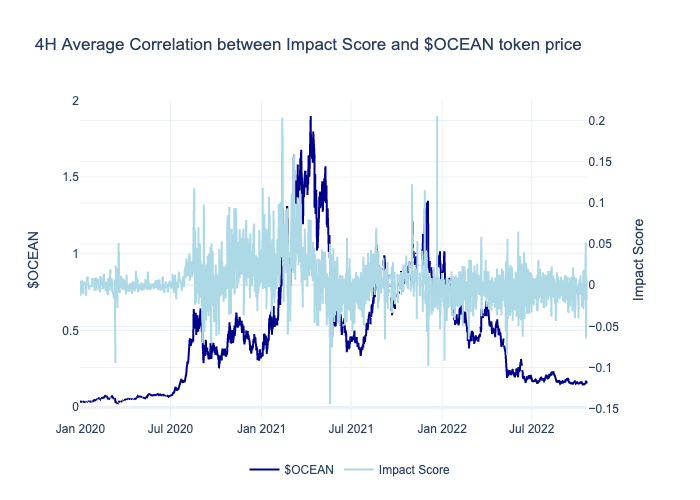

In [86]:
fig = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_tweet_impact_score['date'], y=df_tweet_impact_score['close'],
                         mode='lines',
                         name='$OCEAN',
                         line=dict(color='darkblue', width=2)),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_tweet_impact_score['date'], y=df_tweet_impact_score['impact_score'],
                         mode='lines',
                         name='Impact Score',
                         line=dict(color='lightblue', width=2)),
              secondary_y=True, row=1, col=1)

fig.update_layout(
    title='4H Average Correlation between Impact Score and $OCEAN token price',
    yaxis_title='$OCEAN',
    height=500,  # Adjusted for two subplots
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.2,
        xanchor='center',
        x=0.5
    )
)

fig.update_yaxes(title_text="Impact Score", secondary_y=True, row=1, col=1)

fig.show("png")

In [87]:
df_tweet[df_tweet['impact_score'] == df_tweet['impact_score'].max()]['tweet'].values[0]

'👀🚀🚀🚀  $SXP   Legendary   This will suprise many. I choose this as 1 of the top 5 coins. Ya will find out why.  Follow the smart money✅  $ONE $FET $LUNA $ANC $TRAC $TOMO $ANKR $SXP $OCEAN $BTC $ETH $THETA $ZIL $MIR $SHA $VRA  https://t.co/XimgAmsHhJ'

In [88]:
df_tweet[df_tweet['impact_score'] == df_tweet['impact_score'].min()]['tweet'].values[0]

'$ANKR 4H Chart📈  What happens in the next 2 days is important, either we break out, then retest and head up to the 0.25$ or we dump😬 We need to keep and eye on $btc.d   $OCEAN $RSR $VET $CHZ $FET $LUNA $LINK $DOT $ANKR $LTC $ETH $BTC $ADA $DOGE  https://t.co/5i1MjH6x1Y'

# Tabular Model

In [89]:
df_tabular = df_tweet.copy(deep=True)

### Features

In [90]:
def convert_to_list(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        print(f"Failed to parse: {s}")
        return None  # or however you want to handle failures

Features creation about the tweet

In [91]:
df_tabular["feature_hashtags"]  = df_tabular["hashtags"].apply(convert_to_list).apply(lambda x: len(x))
df_tabular["feature_cashtags"]  = df_tabular["cashtags"].apply(convert_to_list).apply(lambda x: len(x))
df_tabular["feature_mentions"]  = df_tabular["mentions"].apply(convert_to_list).apply(lambda x: len(x))
df_tabular["feature_quote_url"] = df_tabular["quote_url"].notna().astype(int)
df_tabular["feature_video"]     = df_tabular["video"]
df_tabular["feature_thumbnail"] = df_tabular["thumbnail"].notna().astype(int)
df_tabular["feature_reply_to"]  = df_tabular["reply_to"].apply(convert_to_list).apply(lambda x: len(x) > 0).astype(int)
df_tabular["feature_open"]      = df_tabular["open"]

Time encoding

In [92]:
from math import ceil

def week_of_month(dt):
    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

def get_time_indicators(df):
    df['hour'] = df['date'].dt.hour
    df['day_week'] = df['date'].dt.day_of_week
    df['day'] = df['date'].dt.day - 1
    df['week'] = df['date'].apply(week_of_month) - 1
    df['month'] = df['date'].dt.month
    return df

def encode_time_indicators(data, col, max_val):
    data[f'feature_{col}_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[f'feature_{col}_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

def populate_time_indicators(df):
    df = encode_time_indicators(df, 'hour', 23)
    df = encode_time_indicators(df, "day_week", 6)
    df = encode_time_indicators(df, 'day', 30)
    df = encode_time_indicators(df, 'week', 5)
    df = encode_time_indicators(df, 'month', 12)
    return df

In [93]:
df_tabular_time = get_time_indicators(df_tabular[['date']])
df_tabular_time = populate_time_indicators(df_tabular_time)

In [94]:
df_tabular_time = df_tabular_time[[col for col in df_tabular_time if col.startswith('feature_')]]

In [95]:
df_tabular['target'] = df_tabular['impact_score']

In [96]:
df_tabular = df_tabular[['feature_hashtags', 'feature_cashtags', 'feature_mentions', 'feature_quote_url', 'feature_video', 'feature_thumbnail', 'feature_reply_to', 'feature_cum_sum_tweet_count', 'feature_cum_sum_retweet_count', 'feature_cum_sum_likes_count', 'feature_cum_sum_replies_count', 'feature_cum_sum_unique_user_count', 'feature_vader', 'feature_textblob', 'feature_open', 'feature_4h_change', 'target']]

In [97]:
df_tabular = pd.concat([df_tabular_time, df_tabular], axis=1)

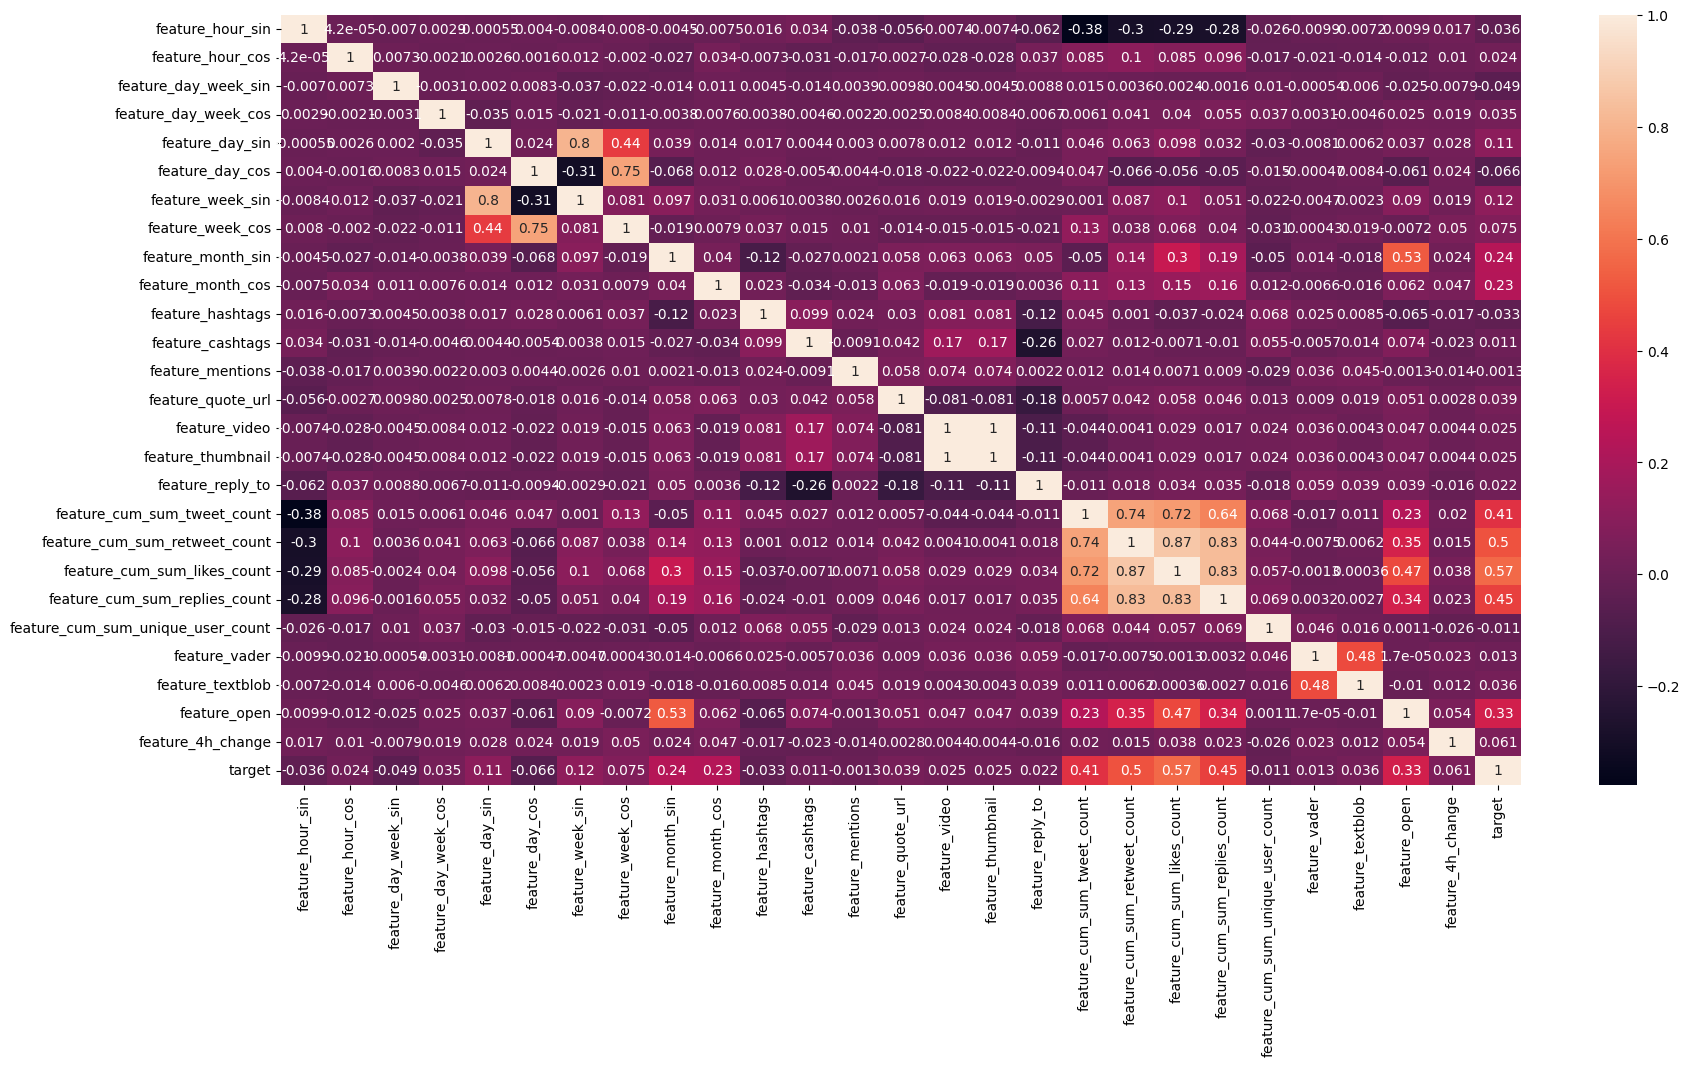

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix from your dataframe
corr = df_tabular.corr()

plt.figure(figsize=(20, 10))
# Create a heatmap
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True)  # This will write the correlation values on the heatmap

plt.show("png")

Split 75% train and 25% test

In [99]:
train_size = int(len(df_tabular) * 0.75)

df_tabular_train = df_tabular[:train_size]
df_tabular_test  = df_tabular[train_size:]

In [100]:
features = [col for col in df_tabular if col.startswith('feature_')]

Normalisation between 0 and 1

In [101]:
scaler = MinMaxScaler()  # default=(0, 1)

# Fit the scaler using the training data and transform it
df_tabular_train.loc[:, features] = scaler.fit_transform(df_tabular_train[features])

# Transform the test data using the scaler fitted on the training data
df_tabular_test.loc[:, features] = scaler.transform(df_tabular_test[features])

### Hyper parameters tuning and Cross validation with Optuna

In [102]:
import optuna
from optuna.samplers import TPESampler
from xgboost import cv, DMatrix, XGBRegressor

def objective(trial):
    param = {
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.3, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.7, 1.0),
        "objective":"reg:squarederror",
        "eval_metric":"rmse"
    }
    
    # Create DMatrix for train data
    dtrain = DMatrix(df_tabular_train[features], label=df_tabular_train['target'])
    
    # Perform cross validation
    scores = cv(param, 
                dtrain, 
                num_boost_round=1000, 
                nfold=5, 
                metrics='rmse', 
                early_stopping_rounds=20,
                stratified=False,
                as_pandas=True)
                
    return scores['test-rmse-mean'].min()

# Create study object
study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(objective, n_trials=10)

# Get the best parameters
best_params = study.best_params

[I 2023-07-23 16:19:38,308] A new study created in memory with name: no-name-9b501c8d-e857-4d48-9776-344ad415bc0c
[I 2023-07-23 16:21:48,895] Trial 0 finished with value: 0.009620143825784687 and parameters: {'colsample_bytree': 0.4348708565482826, 'max_depth': 7, 'learning_rate': 0.09520258810979693, 'subsample': 0.9671050078237906, 'reg_lambda': 0.5443692921557319, 'reg_alpha': 0.8927426664627858}. Best is trial 0 with value: 0.009620143825784687.
[I 2023-07-23 16:22:54,927] Trial 1 finished with value: 0.019862235409308808 and parameters: {'colsample_bytree': 0.629787411099038, 'max_depth': 3, 'learning_rate': 0.04184570042438803, 'subsample': 0.9729092859158435, 'reg_lambda': 0.6297066270793605, 'reg_alpha': 0.9081711045515494}. Best is trial 0 with value: 0.009620143825784687.
[I 2023-07-23 16:27:16,180] Trial 2 finished with value: 0.009919570108039311 and parameters: {'colsample_bytree': 0.7481760003612286, 'max_depth': 10, 'learning_rate': 0.02825796471940488, 'subsample': 0.65

In [103]:
from optuna.visualization import plot_optimization_history, plot_slice, plot_parallel_coordinate

# Plotting the optimization history of the study
optuna.visualization.plot_optimization_history(study)

In [104]:
plot_slice(study)

In [105]:
plot_parallel_coordinate(study)

### Train model with best params

In [106]:
best_model = XGBRegressor(**best_params)
eval_set = [(df_tabular_train[features].values, df_tabular_train['target'].values), 
            (df_tabular_test[features].values, df_tabular_test['target'].values)]
best_model.fit(df_tabular_train[features].values, 
               df_tabular_train['target'].values, 
               eval_set=eval_set, 
               verbose=400)

[0]	validation_0-rmse:0.45286	validation_1-rmse:0.48122
[99]	validation_0-rmse:0.01789	validation_1-rmse:0.03446


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6591282149478346, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05470449124319863,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

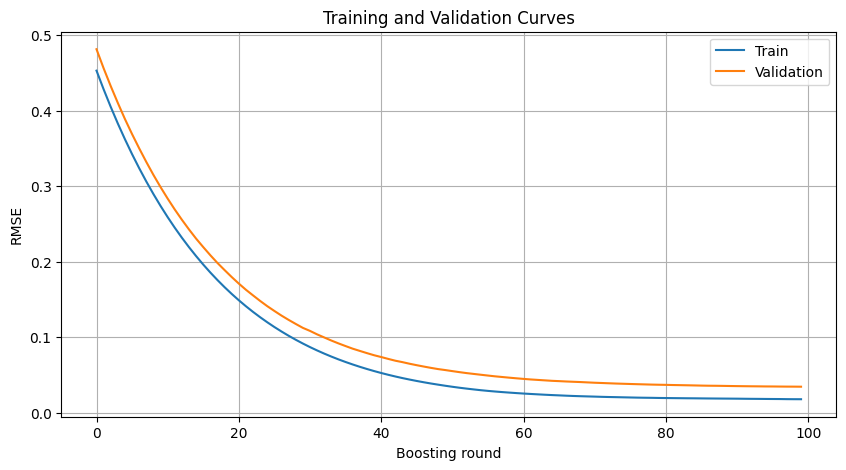

In [107]:
evals_result = best_model.evals_result()

# Create a dataframe from the evaluation results
df_train = pd.DataFrame({"Train": evals_result['validation_0']['rmse']})
df_val = pd.DataFrame({"Validation": evals_result['validation_1']['rmse']})
df = pd.concat([df_train, df_val], axis=1)

# Plot training and validation curves
plt.figure(figsize=(10, 5))
plt.plot(df['Train'], label='Train')
plt.plot(df['Validation'], label='Validation')
plt.xlabel('Boosting round')
plt.ylabel('RMSE')
plt.title('Training and Validation Curves')
plt.legend()
plt.grid(True)
plt.show()

In [108]:
preds = best_model.predict(df_tabular_test[features].values)

In [109]:
df_tabular_test['predictions'] = preds

In [110]:
df_tabular_test['date'] = df_tweet['date'].tail(len(df_tabular_test))

In [111]:
df_tabular_test_h = df_tabular_test.groupby([pd.Grouper(key='date', freq='4H')], as_index=False).agg({'predictions':'mean', 'target':'mean'})

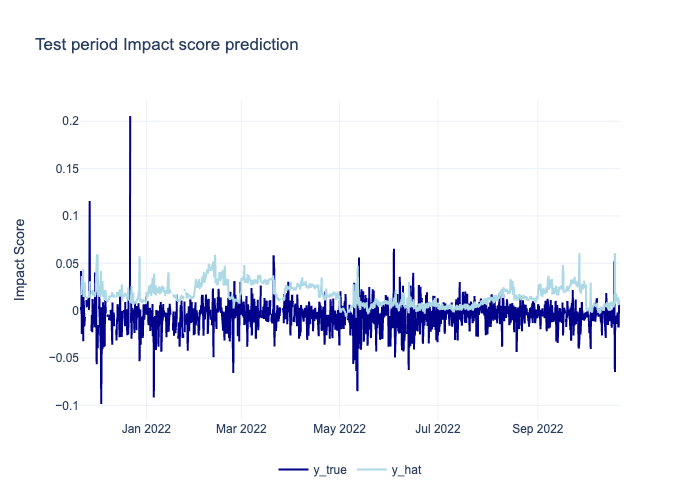

In [112]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Scatter(x=df_tabular_test_h['date'], y=df_tabular_test_h['target'],
                         mode='lines',
                         name='y_true',
                         line=dict(color='darkblue', width=2)),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_tabular_test_h['date'], y=df_tabular_test_h['predictions'],
                         mode='lines',
                         name='y_hat',
                         line=dict(color='lightblue', width=2)),
                row=1, col=1)

fig.update_layout(
    title='Test period Impact score prediction',
    yaxis_title='Impact Score',
    height=500,  # Adjusted for two subplots
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.2,
        xanchor='center',
        x=0.5
    )
)

fig.show("png")

### Evaluation

In [113]:
from sklearn.metrics import mean_squared_error

In [114]:
df_tabular_test_h = df_tabular_test_h.dropna()
rmse = np.sqrt(mean_squared_error(df_tabular_test_h['target'].values, df_tabular_test_h['predictions'].values))
rmse

0.029078856548078208

In [115]:
df_tabular_test['close'] = df_tweet['close'].tail(len(df_tabular_test))

Predictions correlations with price

In [116]:
df_tabular_test['predictions'].corr(df_tabular_test['close'])

0.36081153451674175